# **Description**
- 아래 코드는 **Dropout**과 **Batch Normalization** 기법을 사용하여 Digits 데이터셋에 대해 MLP 모델을 학습하는 코드입니다. 
- PyTorch의 `nn.Sequential`을 사용해 모델을 간단히 정의하였습니다.
    - 기본 모델 vs dropout 적용 모델 vs dropout + batch normalization 적용 모델의 test 결과 비교를 통해 각 기법의 영향을 알아보고자 합니다. 
- 아래 모델 정의 코드 내에 `##답안 코드 작성##` 부분을 채우면서 코드를 실행시켜 주세요!

## **데이터 준비**

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
## 데이터를 훈련용과 테스트용으로 분리
# 전체의 20%는 검증용

digits = load_digits()

X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.int64)

## **Dropout**  
- **Dropout**은 **과적합 방지**를 위해 훈련 시 일부 노드를 확률 $p$로 무작위로 비활성화하는 기법입니다.  
    - 비활성화된 노드의 효과는 **스케일링** $\frac{1}{1-p}$을 통해 살아남은 노드에 보상하여 전체 효과를 유지합니다.  
- Dropout의 **훈련 단계**와 **평가 단계**의 작동 방식은 다릅니다.  
    - **훈련 단계** (`model.train()`): 일부 노드만 활성화되며 다양한 노드 조합을 학습해 **특정 노드 의존도를 줄입니다**.  
    - **평가 단계** (`model.eval()`): 드롭아웃이 비활성화되어 **모든 노드**가 사용되며, 스케일링도 적용되지 않아 **일관된 출력**을 제공합니다.  
> 이를 통해 모델은 **훈련 시 일반화 성능**을 높이고, **평가 시 안정적 결과**를 도출합니다.  

<img src = 'https://d2l.ai/_images/dropout2.svg' width = 500 height = 300>  

(Image Source = https://d2l.ai/_images/dropout2.svg)

In [5]:
### 모델링
## 힌트
# 입력층부터 출력층까지 선형층(Linear), ReLU 활성화 함수, 드롭아웃이 반복되는 구조
# 4개의 은닉층이 있으며 각 은닉층은 100개의 노드를 가짐
# dropout 기법으로 50% 확률로 노드를 비활성화함
    

model = nn.Sequential(
    nn.Linear(64, 100),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(100, 10),
)

In [7]:
### Settings

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

lossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.09it/s]


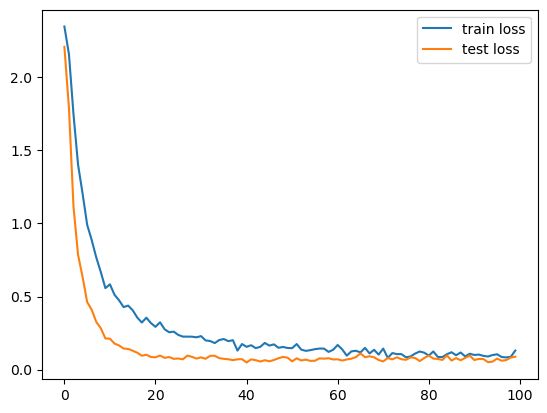

In [9]:
### 학습 & 평가

trainLosses = []
testLosses = []

for epoch in tqdm(range(100)):

    ## 학습(train)
    runningLoss = 0.0
    
    model.train()

    for i, (batchX, batchY) in enumerate(loader):
        optimizer.zero_grad()
        yPred = model(batchX)
        loss = lossFunc(yPred, batchY)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLosses.append(runningLoss/i)
    

    ## 평가(test)
    model.eval()

    yPred = model(X_test)
    testLoss = lossFunc(yPred, Y_test)
    testLosses.append(testLoss.item())

## 결과 시각화
plt.plot(range(100), trainLosses, label = "train loss")
plt.plot(range(100), testLosses, label = "test loss")
plt.legend()

## **Batch Normalization**
- **Batch Normalization**은 신경망의 각 층을 통과할 때 **데이터 분포가 변하는 문제**를 해결하기 위해 데이터를 정규화하는 기법입니다. 
- 입력 데이터만 정규화하는 것으로는 부족하기 때문에, 각 층에서 배치 단위로 평균과 분산을 맞추어 학습을 더 **안정적**이고 **빠르게** 만듭니다. 
- 훈련 시에는 배치 통계를 사용하고, 평가 시에는 훈련 중 기록한 평균과 분산을 사용합니다. 
> 이를 통해 깊은 신경망도 안정적으로 학습할 수 있고 빠르게 수렴하도록 합니다.  

<img src = "https://production-media.paperswithcode.com/methods/batchnorm.png" width = 300 height =300>  

(Image Source: https://production-media.paperswithcode.com/methods/batchnorm.png)

In [15]:
### 모델링
## 힌트
# 입력층부터 출력층까지 선형층(Linear), ReLU 활성화 함수, 배치정규화, 드롭아웃이 반복되는 구조
# 4개의 은닉층이 있으며 각 은닉층은 100개의 노드를 가짐
# dropout 기법으로 50% 확률로 노드를 비활성화함
# 배치 정규화할 출력 차원의 수는 100
    

model = nn.Sequential(
    nn.Linear(64, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.5),

    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.5),

    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.5),

    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.5),
    
    nn.Linear(100, 10),
)

In [17]:
### Settings

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

lossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
### 학습 & 평가

trainLosses = []
testLosses = []

for epoch in tqdm(range(100)):
    ## 학습(train)
    runningLoss = 0.0

    model.train()

    for i, (batchX, batchY) in enumerate(loader):
        optimizer.zero_grad()
        yPred = model(batchX)
        loss = lossFunc(yPred, batchY)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLosses.append(runningLoss/i)
    
    
    ## 평가(test)
    model.eval()

    yPred = model(X_test)
    testLoss = lossFunc(yPred, Y_test)
    testLosses.append(testLoss.item())

### 시각화
plt.plot(range(100), trainLosses, label = "train loss")
plt.plot(range(100), testLosses, label = "test loss")
plt.legend()

 23%|█████████▋                                | 23/100 [00:01<00:05, 14.10it/s]